In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data: points on the curve (x,d)

In [2]:
X = np.loadtxt('X.txt')
D = np.loadtxt('D.txt')

## Details of the neural network

This neural network contains 3 layers

Layer 1 is input layer consists of x and bias point = 1

Layer 2 is a hidden layer consists of 24 neurons and the activation function is tanh

Layer 3 is the output layer which has 1 neuron and there is no activation function (or assume linear)

## Load weights for 2nd and 3rd layer

In [3]:
W_Layer_2_Guess = np.loadtxt('W_Layer_2_InitialGuess.txt')
W_Layer_3_Guess = np.loadtxt('W_Layer_3_InitialGuess.txt')

## Functions for neural network

In [4]:
def ForwardPass(x, W_Layer_2, W_Layer_3):
    # v_2 is the pre activation value in layer 2
    v_2 = np.dot(W_Layer_2, x)
    
    # y_1 is the post activation value in layer 2
    y_2 = np.tanh(v_2)
    
    # v_3 is the pre activation value in layer 3 
    # add bias term for layer 3
    v_3 =  np.dot(W_Layer_3, np.concatenate((np.ones([1,y_2.shape[1]], dtype=float), y_2), axis=0))
    
    # y_3 is the post activation value in layer 3
    y_3 = v_3
    
    return v_2, v_3, y_2, y_3

# example for a single point: 
# x = np.array([X[:,2]]).T
#[v_2, v_3, y_2, y_3] = ForwardPass(x, W_Layer_2, W_Layer_3)

# example for entire dataset
# [v_2, v_3, y_2, y_3] = ForwardPass(X, W_Layer_2, W_Layer_3)

In [5]:
def FeedbackError(output, d):
    value = (2/300)*(d-output)
    return value
#example
# err = FeedbackError(y_3, D[2])

### Backpropagation equations

$\delta_L = (-\frac{dE}{d y_L})\cdot \phi^{\prime}(v_L)$ where $\cdot$ denotes component wise multiplication and for the spcial case of MSE we obtain $\delta_L = (d-y_L)\cdot \phi^{\prime}(V_L)$

$\delta_l = \tilde{W}_{l+1}^T\delta_{l+1} \cdot \phi^{\prime}(v_l)$ for $l = 1,2,\ldots, L-1$ where $\tilde{W}$ is the weight matrix excluding the bias weight

Gradient for layer $l$ is given by $\frac{d E}{d W_l} = - \delta_l \begin{bmatrix} 1 \\ y_{l-1} \end{bmatrix}^T$, for $l = 1,2,\ldots, L$

In [6]:
def derivative_linear(v):
    return np.ones(v.shape, dtype=float)

In [7]:
def derivative_tanh(v):
    #numpy.array([1 - np.square(np.tanh(i)) for i in v])
    value = np.array(1-np.square(np.tanh(v)))
    return value

In [8]:
def BackwardPass(err, x, v_2, v_3, y_2, y_3, W_Layer_3):
    delta_3 = err*derivative_linear(v_3)
    Gradient_Layer_3 = - np.dot(delta_3, np.concatenate((np.ones([1,y_2.shape[1]], dtype=float), y_2), axis=0).T)
    
    #delta_2 =  np.array([(W_Layer_3[1:]*delta_3)*derivative_tanh(v_2)]).T
    delta_2 = np.array([W_Layer_3[1:]*delta_3]).T*derivative_tanh(v_2)
    Gradient_Layer_2 =  -np.dot(delta_2 , x.T)
    
    return Gradient_Layer_2, Gradient_Layer_3


#example
#x = np.array([X[:,2]]).T
#[v_2, v_3, y_2, y_3] = ForwardPass(X[:,2], W_Layer_2, W_Layer_3)
#err = FeedbackError(y_3, D[2])
#[Gradient_Layer_2, Gradient_Layer_3] =BackwardPass(err, x, v_2, v_3, y_2, y_3)

#### Update weights using Backprop

Update weights using gradient descent $W_l \leftarrow W_{l} - \eta \frac{dE}{dW_{l}}$ for $l = 1,2, \ldots, L$

that is update weights using the equation $W_l \leftarrow W_{l} + \eta \delta_{l} \begin{bmatrix} 1\\ y_{l-1} \end{bmatrix}^T$ for $l = 1,2, \ldots, L$

In [9]:
def UpdateWeights_withMomentum(eta, beta, M2, M3, Gradient_Layer_2, Gradient_Layer_3, W_Layer_2, W_Layer_3):
    M2 = (beta * M2) - (eta * Gradient_Layer_2) # Momentum
    M3 = (beta * M3) - (eta * Gradient_Layer_3) # Momentum
    W_Layer_2 = W_Layer_2 + M2
    W_Layer_3 = W_Layer_3 + M3
    return W_Layer_2, W_Layer_3, M2, M3

In [10]:
def UpdateWeights(eta, Gradient_Layer_2, Gradient_Layer_3, W_Layer_2, W_Layer_3):
    W_Layer_2 = W_Layer_2 - (eta*Gradient_Layer_2)
    W_Layer_3 = W_Layer_3 - (eta*Gradient_Layer_3)
    return W_Layer_2, W_Layer_3

#### Calculates the mean square error after every epoch

In [11]:
def CalculateMSE(X, D, output):
    n = len(X.T)
    mse = np.sum(np.square(D-output))/n 
    return mse

#### Reduce the learning if the MSE error overshoots

In [12]:
def CheckLearningrate(eta, MSE_vec, iterations):
    if MSE_vec[iterations] > MSE_vec[iterations-1]:
        eta = 0.4 * eta
    return eta

## Main Loop

In [13]:
#max_iter = 1e4 # Maximum Allowed Iterations
max_iter = 2500
n = len(X.T) # number of samples in training set
tol = 0.005 # Terminating Condition
M2 = 0 # Momentum Vector for Layer 2
M3 = 0 # Momentum Vector for Layer 3
beta = 0.9 # Momentum Parameter

In [14]:
eta = 4 # Learning Rate
W_Layer_2 = W_Layer_2_Guess
W_Layer_3 = W_Layer_3_Guess


MSE_vec = np.zeros(int(max_iter)+1) # Mean Squared Error
MSE_vec[0] = 1

iterations = 1

while iterations < max_iter:
    
    # update the weights for each sample in training set (online learning)
    for i in range(0, n):
        
        x = np.array([X[:,i]]).T
        
        [v_2, v_3, y_2, y_3] = ForwardPass(x, W_Layer_2, W_Layer_3)
        
        err = FeedbackError(y_3, D[i])
        
        [Gradient_Layer_2, Gradient_Layer_3] =BackwardPass(err, x, v_2, v_3, y_2, y_3, W_Layer_3)
        
        #[W_Layer_2, W_Layer_3] = UpdateWeights(eta, Gradient_Layer_2, Gradient_Layer_3, W_Layer_2, W_Layer_3)
        [W_Layer_2, W_Layer_3, M2, M3] = UpdateWeights_withMomentum(eta, beta, M2, M3, Gradient_Layer_2, Gradient_Layer_3, W_Layer_2, W_Layer_3)

    # use the latest weights to obtain outputs for all the training set
    [v_2, v_3, y_2, y_3] = ForwardPass(X, W_Layer_2, W_Layer_3)
    
    # calculate the MSE for the current epoch
    MSE_vec[iterations] = CalculateMSE(X, D, y_3)
    
    print('Epoch: ', iterations, ' MSE: ', MSE_vec[iterations], ' Learning Rate: ', eta, '\n')
    
    if MSE_vec[iterations] < tol:
        print('Optimal Weights Reached')
        break
    
    eta = CheckLearningrate(eta, MSE_vec, iterations)
    iterations += 1

Epoch:  1  MSE:  0.5489863481025009  Learning Rate:  4 

Epoch:  2  MSE:  0.5292952247012037  Learning Rate:  4 

Epoch:  3  MSE:  0.5265427348766326  Learning Rate:  4 

Epoch:  4  MSE:  0.5286789360138326  Learning Rate:  4 

Epoch:  5  MSE:  0.5317595495225776  Learning Rate:  1.6 

Epoch:  6  MSE:  0.5036883799173667  Learning Rate:  0.6400000000000001 

Epoch:  7  MSE:  0.5029335230617028  Learning Rate:  0.6400000000000001 

Epoch:  8  MSE:  0.5023216016109919  Learning Rate:  0.6400000000000001 

Epoch:  9  MSE:  0.5018134823106999  Learning Rate:  0.6400000000000001 

Epoch:  10  MSE:  0.5013833860861927  Learning Rate:  0.6400000000000001 

Epoch:  11  MSE:  0.5010137298112668  Learning Rate:  0.6400000000000001 

Epoch:  12  MSE:  0.5006920090561278  Learning Rate:  0.6400000000000001 

Epoch:  13  MSE:  0.5004090072094404  Learning Rate:  0.6400000000000001 

Epoch:  14  MSE:  0.5001577440328486  Learning Rate:  0.6400000000000001 

Epoch:  15  MSE:  0.4999328249979472  Lear

Epoch:  113  MSE:  0.49506542352555  Learning Rate:  0.6400000000000001 

Epoch:  114  MSE:  0.49503742035024556  Learning Rate:  0.6400000000000001 

Epoch:  115  MSE:  0.49500919548071315  Learning Rate:  0.6400000000000001 

Epoch:  116  MSE:  0.49498070879693207  Learning Rate:  0.6400000000000001 

Epoch:  117  MSE:  0.49495191872244104  Learning Rate:  0.6400000000000001 

Epoch:  118  MSE:  0.4949227821692284  Learning Rate:  0.6400000000000001 

Epoch:  119  MSE:  0.4948932544547343  Learning Rate:  0.6400000000000001 

Epoch:  120  MSE:  0.49486328919077766  Learning Rate:  0.6400000000000001 

Epoch:  121  MSE:  0.4948328381442525  Learning Rate:  0.6400000000000001 

Epoch:  122  MSE:  0.4948018510693739  Learning Rate:  0.6400000000000001 

Epoch:  123  MSE:  0.49477027551110553  Learning Rate:  0.6400000000000001 

Epoch:  124  MSE:  0.4947380565791404  Learning Rate:  0.6400000000000001 

Epoch:  125  MSE:  0.4947051366915187  Learning Rate:  0.6400000000000001 

Epoch:  

Epoch:  222  MSE:  0.48798236183727134  Learning Rate:  0.6400000000000001 

Epoch:  223  MSE:  0.4879651293793403  Learning Rate:  0.6400000000000001 

Epoch:  224  MSE:  0.487947787891619  Learning Rate:  0.6400000000000001 

Epoch:  225  MSE:  0.48793033444965345  Learning Rate:  0.6400000000000001 

Epoch:  226  MSE:  0.48791276624650676  Learning Rate:  0.6400000000000001 

Epoch:  227  MSE:  0.48789508058755415  Learning Rate:  0.6400000000000001 

Epoch:  228  MSE:  0.4878772748857752  Learning Rate:  0.6400000000000001 

Epoch:  229  MSE:  0.4878593466574442  Learning Rate:  0.6400000000000001 

Epoch:  230  MSE:  0.48784129351815525  Learning Rate:  0.6400000000000001 

Epoch:  231  MSE:  0.48782311317912047  Learning Rate:  0.6400000000000001 

Epoch:  232  MSE:  0.4878048034437  Learning Rate:  0.6400000000000001 

Epoch:  233  MSE:  0.48778636220412847  Learning Rate:  0.6400000000000001 

Epoch:  234  MSE:  0.48776778743841004  Learning Rate:  0.6400000000000001 

Epoch:  

Epoch:  330  MSE:  0.48522635472758907  Learning Rate:  0.6400000000000001 

Epoch:  331  MSE:  0.48519143479532756  Learning Rate:  0.6400000000000001 

Epoch:  332  MSE:  0.4851563425808691  Learning Rate:  0.6400000000000001 

Epoch:  333  MSE:  0.4851210786698738  Learning Rate:  0.6400000000000001 

Epoch:  334  MSE:  0.4850856436738128  Learning Rate:  0.6400000000000001 

Epoch:  335  MSE:  0.4850500382296573  Learning Rate:  0.6400000000000001 

Epoch:  336  MSE:  0.4850142629995251  Learning Rate:  0.6400000000000001 

Epoch:  337  MSE:  0.48497831867029123  Learning Rate:  0.6400000000000001 

Epoch:  338  MSE:  0.4849422059531639  Learning Rate:  0.6400000000000001 

Epoch:  339  MSE:  0.4849059255832233  Learning Rate:  0.6400000000000001 

Epoch:  340  MSE:  0.48486947831893107  Learning Rate:  0.6400000000000001 

Epoch:  341  MSE:  0.4848328649416045  Learning Rate:  0.6400000000000001 

Epoch:  342  MSE:  0.4847960862548637  Learning Rate:  0.6400000000000001 

Epoch:  

Epoch:  438  MSE:  0.48064323839553824  Learning Rate:  0.6400000000000001 

Epoch:  439  MSE:  0.4805946371953409  Learning Rate:  0.6400000000000001 

Epoch:  440  MSE:  0.4805459268575991  Learning Rate:  0.6400000000000001 

Epoch:  441  MSE:  0.48049710624194936  Learning Rate:  0.6400000000000001 

Epoch:  442  MSE:  0.48044817413603447  Learning Rate:  0.6400000000000001 

Epoch:  443  MSE:  0.48039912925378286  Learning Rate:  0.6400000000000001 

Epoch:  444  MSE:  0.48034997023364817  Learning Rate:  0.6400000000000001 

Epoch:  445  MSE:  0.4803006956367941  Learning Rate:  0.6400000000000001 

Epoch:  446  MSE:  0.48025130394523446  Learning Rate:  0.6400000000000001 

Epoch:  447  MSE:  0.48020179355992326  Learning Rate:  0.6400000000000001 

Epoch:  448  MSE:  0.4801521627987915  Learning Rate:  0.6400000000000001 

Epoch:  449  MSE:  0.4801024098947296  Learning Rate:  0.6400000000000001 

Epoch:  450  MSE:  0.4800525329935189  Learning Rate:  0.6400000000000001 

Epoch

Epoch:  547  MSE:  0.4737572379567475  Learning Rate:  0.6400000000000001 

Epoch:  548  MSE:  0.4736599581175751  Learning Rate:  0.6400000000000001 

Epoch:  549  MSE:  0.4735614772074185  Learning Rate:  0.6400000000000001 

Epoch:  550  MSE:  0.4734617756951902  Learning Rate:  0.6400000000000001 

Epoch:  551  MSE:  0.473360834223913  Learning Rate:  0.6400000000000001 

Epoch:  552  MSE:  0.4732586336379846  Learning Rate:  0.6400000000000001 

Epoch:  553  MSE:  0.473155155010982  Learning Rate:  0.6400000000000001 

Epoch:  554  MSE:  0.47305037967395464  Learning Rate:  0.6400000000000001 

Epoch:  555  MSE:  0.4729442892441468  Learning Rate:  0.6400000000000001 

Epoch:  556  MSE:  0.4728368656540919  Learning Rate:  0.6400000000000001 

Epoch:  557  MSE:  0.4727280911810189  Learning Rate:  0.6400000000000001 

Epoch:  558  MSE:  0.4726179484764991  Learning Rate:  0.6400000000000001 

Epoch:  559  MSE:  0.47250642059626613  Learning Rate:  0.6400000000000001 

Epoch:  560 

Epoch:  657  MSE:  0.45515074111041076  Learning Rate:  0.6400000000000001 

Epoch:  658  MSE:  0.4549392541551156  Learning Rate:  0.6400000000000001 

Epoch:  659  MSE:  0.4547279500259238  Learning Rate:  0.6400000000000001 

Epoch:  660  MSE:  0.4545168504442852  Learning Rate:  0.6400000000000001 

Epoch:  661  MSE:  0.45430597659481653  Learning Rate:  0.6400000000000001 

Epoch:  662  MSE:  0.4540953491190809  Learning Rate:  0.6400000000000001 

Epoch:  663  MSE:  0.45388498810992817  Learning Rate:  0.6400000000000001 

Epoch:  664  MSE:  0.4536749131063555  Learning Rate:  0.6400000000000001 

Epoch:  665  MSE:  0.45346514308888203  Learning Rate:  0.6400000000000001 

Epoch:  666  MSE:  0.453255696475395  Learning Rate:  0.6400000000000001 

Epoch:  667  MSE:  0.453046591117455  Learning Rate:  0.6400000000000001 

Epoch:  668  MSE:  0.45283784429702356  Learning Rate:  0.6400000000000001 

Epoch:  669  MSE:  0.4526294727236015  Learning Rate:  0.6400000000000001 

Epoch:  6

Epoch:  768  MSE:  0.4342613326723591  Learning Rate:  0.6400000000000001 

Epoch:  769  MSE:  0.4340832005889457  Learning Rate:  0.6400000000000001 

Epoch:  770  MSE:  0.43390472179523043  Learning Rate:  0.6400000000000001 

Epoch:  771  MSE:  0.4337258793849552  Learning Rate:  0.6400000000000001 

Epoch:  772  MSE:  0.4335466554164235  Learning Rate:  0.6400000000000001 

Epoch:  773  MSE:  0.43336703070838195  Learning Rate:  0.6400000000000001 

Epoch:  774  MSE:  0.4331869846135825  Learning Rate:  0.6400000000000001 

Epoch:  775  MSE:  0.43300649476719355  Learning Rate:  0.6400000000000001 

Epoch:  776  MSE:  0.4328255368065797  Learning Rate:  0.6400000000000001 

Epoch:  777  MSE:  0.43264408405818033  Learning Rate:  0.6400000000000001 

Epoch:  778  MSE:  0.4324621071861971  Learning Rate:  0.6400000000000001 

Epoch:  779  MSE:  0.43227957379657217  Learning Rate:  0.6400000000000001 

Epoch:  780  MSE:  0.43209644798818353  Learning Rate:  0.6400000000000001 

Epoch:

Epoch:  983  MSE:  0.2590254386404935  Learning Rate:  0.6400000000000001 

Epoch:  984  MSE:  0.25814235419199644  Learning Rate:  0.6400000000000001 

Epoch:  985  MSE:  0.25726389091314594  Learning Rate:  0.6400000000000001 

Epoch:  986  MSE:  0.2563904855613421  Learning Rate:  0.6400000000000001 

Epoch:  987  MSE:  0.2555225441091217  Learning Rate:  0.6400000000000001 

Epoch:  988  MSE:  0.2546604409010817  Learning Rate:  0.6400000000000001 

Epoch:  989  MSE:  0.2538045181564338  Learning Rate:  0.6400000000000001 

Epoch:  990  MSE:  0.25295508579131637  Learning Rate:  0.6400000000000001 

Epoch:  991  MSE:  0.2521124215318163  Learning Rate:  0.6400000000000001 

Epoch:  992  MSE:  0.25127677128665504  Learning Rate:  0.6400000000000001 

Epoch:  993  MSE:  0.25044834974736024  Learning Rate:  0.6400000000000001 

Epoch:  994  MSE:  0.24962734118365015  Learning Rate:  0.6400000000000001 

Epoch:  995  MSE:  0.24881390040233423  Learning Rate:  0.6400000000000001 

Epoch

Epoch:  1091  MSE:  0.18800533708641634  Learning Rate:  0.6400000000000001 

Epoch:  1092  MSE:  0.18728327009987158  Learning Rate:  0.6400000000000001 

Epoch:  1093  MSE:  0.18655452157848942  Learning Rate:  0.6400000000000001 

Epoch:  1094  MSE:  0.18581897961134494  Learning Rate:  0.6400000000000001 

Epoch:  1095  MSE:  0.1850765325109025  Learning Rate:  0.6400000000000001 

Epoch:  1096  MSE:  0.1843270683131367  Learning Rate:  0.6400000000000001 

Epoch:  1097  MSE:  0.18357047416884478  Learning Rate:  0.6400000000000001 

Epoch:  1098  MSE:  0.18280663560858432  Learning Rate:  0.6400000000000001 

Epoch:  1099  MSE:  0.18203543566212047  Learning Rate:  0.6400000000000001 

Epoch:  1100  MSE:  0.1812567538119319  Learning Rate:  0.6400000000000001 

Epoch:  1101  MSE:  0.1804704647593238  Learning Rate:  0.6400000000000001 

Epoch:  1102  MSE:  0.1796764369813231  Learning Rate:  0.6400000000000001 

Epoch:  1103  MSE:  0.17887453105669593  Learning Rate:  0.6400000000

Epoch:  1198  MSE:  0.06215119284904806  Learning Rate:  0.6400000000000001 

Epoch:  1199  MSE:  0.06146177054932636  Learning Rate:  0.6400000000000001 

Epoch:  1200  MSE:  0.06080663597495973  Learning Rate:  0.6400000000000001 

Epoch:  1201  MSE:  0.060184648440943934  Learning Rate:  0.6400000000000001 

Epoch:  1202  MSE:  0.059594612462001754  Learning Rate:  0.6400000000000001 

Epoch:  1203  MSE:  0.05903529341121969  Learning Rate:  0.6400000000000001 

Epoch:  1204  MSE:  0.058505431602031636  Learning Rate:  0.6400000000000001 

Epoch:  1205  MSE:  0.05800375479919469  Learning Rate:  0.6400000000000001 

Epoch:  1206  MSE:  0.05752898919870455  Learning Rate:  0.6400000000000001 

Epoch:  1207  MSE:  0.05707986894272892  Learning Rate:  0.6400000000000001 

Epoch:  1208  MSE:  0.05665514425412345  Learning Rate:  0.6400000000000001 

Epoch:  1209  MSE:  0.056253588287725954  Learning Rate:  0.6400000000000001 

Epoch:  1210  MSE:  0.055874002802884834  Learning Rate:  0.

Epoch:  1304  MSE:  0.04736975756459047  Learning Rate:  0.6400000000000001 

Epoch:  1305  MSE:  0.04733146300494514  Learning Rate:  0.6400000000000001 

Epoch:  1306  MSE:  0.04729305186939779  Learning Rate:  0.6400000000000001 

Epoch:  1307  MSE:  0.047254515425243705  Learning Rate:  0.6400000000000001 

Epoch:  1308  MSE:  0.047215845105567394  Learning Rate:  0.6400000000000001 

Epoch:  1309  MSE:  0.04717703250178695  Learning Rate:  0.6400000000000001 

Epoch:  1310  MSE:  0.04713806935685854  Learning Rate:  0.6400000000000001 

Epoch:  1311  MSE:  0.04709894755911724  Learning Rate:  0.6400000000000001 

Epoch:  1312  MSE:  0.04705965913669385  Learning Rate:  0.6400000000000001 

Epoch:  1313  MSE:  0.04702019625247465  Learning Rate:  0.6400000000000001 

Epoch:  1314  MSE:  0.046980551199562265  Learning Rate:  0.6400000000000001 

Epoch:  1315  MSE:  0.04694071639719966  Learning Rate:  0.6400000000000001 

Epoch:  1316  MSE:  0.046900684387128355  Learning Rate:  0.6

Epoch:  1410  MSE:  0.041521890058799575  Learning Rate:  0.6400000000000001 

Epoch:  1411  MSE:  0.041442167812990115  Learning Rate:  0.6400000000000001 

Epoch:  1412  MSE:  0.04136188936902415  Learning Rate:  0.6400000000000001 

Epoch:  1413  MSE:  0.041281052941468166  Learning Rate:  0.6400000000000001 

Epoch:  1414  MSE:  0.041199656839715666  Learning Rate:  0.6400000000000001 

Epoch:  1415  MSE:  0.0411176994761643  Learning Rate:  0.6400000000000001 

Epoch:  1416  MSE:  0.0410351793746639  Learning Rate:  0.6400000000000001 

Epoch:  1417  MSE:  0.040952095179223394  Learning Rate:  0.6400000000000001 

Epoch:  1418  MSE:  0.04086844566294718  Learning Rate:  0.6400000000000001 

Epoch:  1419  MSE:  0.040784229737189696  Learning Rate:  0.6400000000000001 

Epoch:  1420  MSE:  0.040699446460897896  Learning Rate:  0.6400000000000001 

Epoch:  1421  MSE:  0.040614095050126434  Learning Rate:  0.6400000000000001 

Epoch:  1422  MSE:  0.04052817488769658  Learning Rate:  0

Epoch:  1517  MSE:  0.030617310954327993  Learning Rate:  0.6400000000000001 

Epoch:  1518  MSE:  0.030509798339502958  Learning Rate:  0.6400000000000001 

Epoch:  1519  MSE:  0.03040247389610266  Learning Rate:  0.6400000000000001 

Epoch:  1520  MSE:  0.03029533730717983  Learning Rate:  0.6400000000000001 

Epoch:  1521  MSE:  0.03018838782676975  Learning Rate:  0.6400000000000001 

Epoch:  1522  MSE:  0.03008162428875616  Learning Rate:  0.6400000000000001 

Epoch:  1523  MSE:  0.029975045116622998  Learning Rate:  0.6400000000000001 

Epoch:  1524  MSE:  0.029868648334115733  Learning Rate:  0.6400000000000001 

Epoch:  1525  MSE:  0.029762431576795964  Learning Rate:  0.6400000000000001 

Epoch:  1526  MSE:  0.029656392104534555  Learning Rate:  0.6400000000000001 

Epoch:  1527  MSE:  0.029550526814904422  Learning Rate:  0.6400000000000001 

Epoch:  1528  MSE:  0.029444832257523968  Learning Rate:  0.6400000000000001 

Epoch:  1529  MSE:  0.029339304649347375  Learning Rate:

Epoch:  1625  MSE:  0.019579294294415826  Learning Rate:  0.6400000000000001 

Epoch:  1626  MSE:  0.019485652593295398  Learning Rate:  0.6400000000000001 

Epoch:  1627  MSE:  0.01939238268330119  Learning Rate:  0.6400000000000001 

Epoch:  1628  MSE:  0.019299491016897798  Learning Rate:  0.6400000000000001 

Epoch:  1629  MSE:  0.019206983948397257  Learning Rate:  0.6400000000000001 

Epoch:  1630  MSE:  0.019114867731280776  Learning Rate:  0.6400000000000001 

Epoch:  1631  MSE:  0.019023148515573025  Learning Rate:  0.6400000000000001 

Epoch:  1632  MSE:  0.018931832345328338  Learning Rate:  0.6400000000000001 

Epoch:  1633  MSE:  0.018840925156193372  Learning Rate:  0.6400000000000001 

Epoch:  1634  MSE:  0.018750432773064707  Learning Rate:  0.6400000000000001 

Epoch:  1635  MSE:  0.0186603609078263  Learning Rate:  0.6400000000000001 

Epoch:  1636  MSE:  0.018570715157196094  Learning Rate:  0.6400000000000001 

Epoch:  1637  MSE:  0.01848150100065076  Learning Rate:

Epoch:  1733  MSE:  0.012280883826106235  Learning Rate:  0.6400000000000001 

Epoch:  1734  MSE:  0.012240213127647913  Learning Rate:  0.6400000000000001 

Epoch:  1735  MSE:  0.012199955267518358  Learning Rate:  0.6400000000000001 

Epoch:  1736  MSE:  0.012160106682173993  Learning Rate:  0.6400000000000001 

Epoch:  1737  MSE:  0.012120663798237653  Learning Rate:  0.6400000000000001 

Epoch:  1738  MSE:  0.012081623033877513  Learning Rate:  0.6400000000000001 

Epoch:  1739  MSE:  0.01204298080014159  Learning Rate:  0.6400000000000001 

Epoch:  1740  MSE:  0.01200473350227862  Learning Rate:  0.6400000000000001 

Epoch:  1741  MSE:  0.01196687754101695  Learning Rate:  0.6400000000000001 

Epoch:  1742  MSE:  0.011929409313820968  Learning Rate:  0.6400000000000001 

Epoch:  1743  MSE:  0.011892325216113683  Learning Rate:  0.6400000000000001 

Epoch:  1744  MSE:  0.011855621642472934  Learning Rate:  0.6400000000000001 

Epoch:  1745  MSE:  0.011819294987798075  Learning Rate

Epoch:  1839  MSE:  0.00962377015294417  Learning Rate:  0.6400000000000001 

Epoch:  1840  MSE:  0.00960928027757592  Learning Rate:  0.6400000000000001 

Epoch:  1841  MSE:  0.00959491018725292  Learning Rate:  0.6400000000000001 

Epoch:  1842  MSE:  0.009580658378456463  Learning Rate:  0.6400000000000001 

Epoch:  1843  MSE:  0.009566523368736668  Learning Rate:  0.6400000000000001 

Epoch:  1844  MSE:  0.009552503696499078  Learning Rate:  0.6400000000000001 

Epoch:  1845  MSE:  0.00953859792078904  Learning Rate:  0.6400000000000001 

Epoch:  1846  MSE:  0.009524804621071541  Learning Rate:  0.6400000000000001 

Epoch:  1847  MSE:  0.009511122397017452  Learning Rate:  0.6400000000000001 

Epoch:  1848  MSE:  0.00949754986828489  Learning Rate:  0.6400000000000001 

Epoch:  1849  MSE:  0.009484085674300997  Learning Rate:  0.6400000000000001 

Epoch:  1850  MSE:  0.009470728474042142  Learning Rate:  0.6400000000000001 

Epoch:  1851  MSE:  0.00945747694581816  Learning Rate:  

Epoch:  1944  MSE:  0.008554928170099384  Learning Rate:  0.6400000000000001 

Epoch:  1945  MSE:  0.00854776872127305  Learning Rate:  0.6400000000000001 

Epoch:  1946  MSE:  0.00854064867239702  Learning Rate:  0.6400000000000001 

Epoch:  1947  MSE:  0.008533567702501256  Learning Rate:  0.6400000000000001 

Epoch:  1948  MSE:  0.008526525494609994  Learning Rate:  0.6400000000000001 

Epoch:  1949  MSE:  0.008519521735656316  Learning Rate:  0.6400000000000001 

Epoch:  1950  MSE:  0.008512556116405945  Learning Rate:  0.6400000000000001 

Epoch:  1951  MSE:  0.008505628331379068  Learning Rate:  0.6400000000000001 

Epoch:  1952  MSE:  0.008498738078773433  Learning Rate:  0.6400000000000001 

Epoch:  1953  MSE:  0.00849188506039054  Learning Rate:  0.6400000000000001 

Epoch:  1954  MSE:  0.008485068981558699  Learning Rate:  0.6400000000000001 

Epoch:  1955  MSE:  0.008478289551064548  Learning Rate:  0.6400000000000001 

Epoch:  1956  MSE:  0.008471546481079516  Learning Rate

Epoch:  2052  MSE:  0.007958607574618158  Learning Rate:  0.6400000000000001 

Epoch:  2053  MSE:  0.007954366141407793  Learning Rate:  0.6400000000000001 

Epoch:  2054  MSE:  0.007950142272884398  Learning Rate:  0.6400000000000001 

Epoch:  2055  MSE:  0.007945935836323201  Learning Rate:  0.6400000000000001 

Epoch:  2056  MSE:  0.00794174669990936  Learning Rate:  0.6400000000000001 

Epoch:  2057  MSE:  0.00793757473273489  Learning Rate:  0.6400000000000001 

Epoch:  2058  MSE:  0.007933419804802224  Learning Rate:  0.6400000000000001 

Epoch:  2059  MSE:  0.00792928178701958  Learning Rate:  0.6400000000000001 

Epoch:  2060  MSE:  0.00792516055119922  Learning Rate:  0.6400000000000001 

Epoch:  2061  MSE:  0.007921055970057959  Learning Rate:  0.6400000000000001 

Epoch:  2062  MSE:  0.007916967917215682  Learning Rate:  0.6400000000000001 

Epoch:  2063  MSE:  0.00791289626719241  Learning Rate:  0.6400000000000001 

Epoch:  2064  MSE:  0.00790884089541085  Learning Rate:  

Epoch:  2157  MSE:  0.007588465803735038  Learning Rate:  0.6400000000000001 

Epoch:  2158  MSE:  0.007585505499213671  Learning Rate:  0.6400000000000001 

Epoch:  2159  MSE:  0.0075825533769115485  Learning Rate:  0.6400000000000001 

Epoch:  2160  MSE:  0.007579609384721322  Learning Rate:  0.6400000000000001 

Epoch:  2161  MSE:  0.007576673471058877  Learning Rate:  0.6400000000000001 

Epoch:  2162  MSE:  0.007573745584861872  Learning Rate:  0.6400000000000001 

Epoch:  2163  MSE:  0.007570825675585143  Learning Rate:  0.6400000000000001 

Epoch:  2164  MSE:  0.0075679136931910895  Learning Rate:  0.6400000000000001 

Epoch:  2165  MSE:  0.007565009588148175  Learning Rate:  0.6400000000000001 

Epoch:  2166  MSE:  0.007562113311424431  Learning Rate:  0.6400000000000001 

Epoch:  2167  MSE:  0.007559224814482034  Learning Rate:  0.6400000000000001 

Epoch:  2168  MSE:  0.007556344049273414  Learning Rate:  0.6400000000000001 

Epoch:  2169  MSE:  0.00755347096823316  Learning 

Epoch:  2261  MSE:  0.007316904254163195  Learning Rate:  0.6400000000000001 

Epoch:  2262  MSE:  0.007314590004318526  Learning Rate:  0.6400000000000001 

Epoch:  2263  MSE:  0.007312280514342626  Learning Rate:  0.6400000000000001 

Epoch:  2264  MSE:  0.0073099757644162384  Learning Rate:  0.6400000000000001 

Epoch:  2265  MSE:  0.007307675734876359  Learning Rate:  0.6400000000000001 

Epoch:  2266  MSE:  0.007305380406213741  Learning Rate:  0.6400000000000001 

Epoch:  2267  MSE:  0.007303089759071429  Learning Rate:  0.6400000000000001 

Epoch:  2268  MSE:  0.007300803774244087  Learning Rate:  0.6400000000000001 

Epoch:  2269  MSE:  0.007298522432674117  Learning Rate:  0.6400000000000001 

Epoch:  2270  MSE:  0.007296245715452216  Learning Rate:  0.6400000000000001 

Epoch:  2271  MSE:  0.007293973603814213  Learning Rate:  0.6400000000000001 

Epoch:  2272  MSE:  0.007291706079138898  Learning Rate:  0.6400000000000001 

Epoch:  2273  MSE:  0.007289443122949119  Learning 

Epoch:  2365  MSE:  0.007098688267278333  Learning Rate:  0.6400000000000001 

Epoch:  2366  MSE:  0.007096784771324886  Learning Rate:  0.6400000000000001 

Epoch:  2367  MSE:  0.007094884566179062  Learning Rate:  0.6400000000000001 

Epoch:  2368  MSE:  0.00709298764176823  Learning Rate:  0.6400000000000001 

Epoch:  2369  MSE:  0.007091093988074211  Learning Rate:  0.6400000000000001 

Epoch:  2370  MSE:  0.007089203595128759  Learning Rate:  0.6400000000000001 

Epoch:  2371  MSE:  0.007087316453019108  Learning Rate:  0.6400000000000001 

Epoch:  2372  MSE:  0.0070854325518826195  Learning Rate:  0.6400000000000001 

Epoch:  2373  MSE:  0.0070835518819082595  Learning Rate:  0.6400000000000001 

Epoch:  2374  MSE:  0.007081674433337136  Learning Rate:  0.6400000000000001 

Epoch:  2375  MSE:  0.007079800196460241  Learning Rate:  0.6400000000000001 

Epoch:  2376  MSE:  0.007077929161618314  Learning Rate:  0.6400000000000001 

Epoch:  2377  MSE:  0.007076061319202804  Learning 

Epoch:  2469  MSE:  0.006916725567103475  Learning Rate:  0.6400000000000001 

Epoch:  2470  MSE:  0.0069151183583856905  Learning Rate:  0.6400000000000001 

Epoch:  2471  MSE:  0.00691351361394247  Learning Rate:  0.6400000000000001 

Epoch:  2472  MSE:  0.006911911327504214  Learning Rate:  0.6400000000000001 

Epoch:  2473  MSE:  0.006910311492822799  Learning Rate:  0.6400000000000001 

Epoch:  2474  MSE:  0.0069087141036779055  Learning Rate:  0.6400000000000001 

Epoch:  2475  MSE:  0.006907119153872482  Learning Rate:  0.6400000000000001 

Epoch:  2476  MSE:  0.006905526637233293  Learning Rate:  0.6400000000000001 

Epoch:  2477  MSE:  0.006903936547610427  Learning Rate:  0.6400000000000001 

Epoch:  2478  MSE:  0.006902348878880407  Learning Rate:  0.6400000000000001 

Epoch:  2479  MSE:  0.0069007636249415385  Learning Rate:  0.6400000000000001 

Epoch:  2480  MSE:  0.006899180779717421  Learning Rate:  0.6400000000000001 

Epoch:  2481  MSE:  0.00689760033715315  Learning 

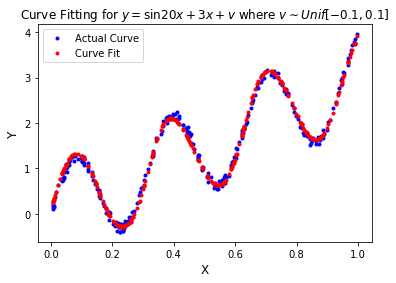

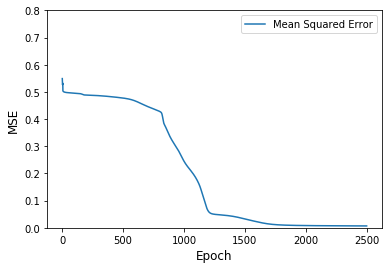

In [17]:
# Plot
# Plot 1
fig, ax1 = plt.subplots()  
[v_2, v_3, y_2, y_3] = ForwardPass(X, W_Layer_2, W_Layer_3)    
ax1.plot(X[1,:].T, D, 'b.', label='Actual Curve')
ax1.plot(X[1,:].T, y_3, 'r.', label='Curve Fit')
plt.title(r'Curve Fitting for $ y = \sin{20x} + 3 x + v $ where $v \sim Unif[-0.1, 0.1] $', fontsize=12)
plt.xlabel(r'X', fontsize=12)
plt.ylabel(r'Y', fontsize=12)
plt.legend()

plt.savefig('actualCurveVsFit_momentum.png', dpi = 450)
plt.show()


# Plot 2
fig, ax2 = plt.subplots()
ax2.plot(np.linspace(1, iterations-1, num=iterations-1), MSE_vec[1:int(max_iter)], label='Mean Squared Error')
#plt.title('No of Training Iterations VS Mean Squared Error (MSE)')
plt.xlabel(r'Epoch', fontsize=12)
plt.ylabel(r'MSE', fontsize=12)
plt.legend()
plt.ylim([0, 0.8])
plt.savefig('MSEVsIter_momentum.png', dpi = 450)
plt.show()